# Create aWhere Grid from Shapefile

## Environment Setup

### Imports

In [1]:
# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import earthpy as et

### Functions

In [2]:
def create_awhere_grid(study_area_path, buffer_distance, cell_size=0.08):
    """Creates an aWhere-sized grid (0.08 x 0.08 degree,
    5 arc-minute x 5 arc-minute grid) fit to a polygon.

    Parameters
    ----------
    study_area_path : str
        Path the polygon shapefile boundary.

    buffer_distance : int or float
        Buffer size in degrees (WGS 84 CRS).

    cell_size: int or float
        Grid size (x and y dimension) in degrees (WGS 84 CRS).

    Returns
    -------
    study_area_grid_4326: geopandas GeoDataFrame
        Grid dataframe shaped to the polygon boundary.

    Example
    -------
    """
    # Read shapefile into geodataframe
    study_area = gpd.read_file(study_area_path)

    # Project to WGS 84 Lat/Lon, EPSG 4326 if no CRS match
    if not study_area.crs == 4326:
        study_area_4326 = study_area.to_crs(4326)

    else:
        study_area_4326 = study_area

    # Create buffer around state boundary
    study_area_4326_buffer = study_area_4326.buffer(distance=buffer_distance)

    # Convert buffer from geoseries to geodataframe
    study_area_4326_buffer_gdf = gpd.GeoDataFrame(
        study_area_4326_buffer, crs=4326)

    # Rename geometry column in buffer
    study_area_4326_buffer_gdf.rename(columns={0: 'geometry'}, inplace=True)

    # Get extent of buffered boundary
    longitude_min = study_area_4326_buffer_gdf.bounds.minx[0]
    latitude_min = study_area_4326_buffer_gdf.bounds.miny[0]
    longitude_max = study_area_4326_buffer_gdf.bounds.maxx[0]
    latitude_max = study_area_4326_buffer_gdf.bounds.maxy[0]

    # Create lists for lat/lon extents
    # DOES THIS NEED ANY PADDING? np.floor, np.ceil?
    # OR DOES DUFFER DISTANCE HANDLE THIS?
    longitude_vals = np.arange(longitude_min, longitude_max, cell_size)
    latitude_vals = np.arange(latitude_min, latitude_max, cell_size)

    # Create grid of polygons based on longitude and latitude ranges
    grid_polys_list = [Polygon([
        (longitude, latitude),
        (longitude + cell_size, latitude),
        (longitude + cell_size, latitude + cell_size),
        (longitude, latitude + cell_size)])
        for longitude in longitude_vals for latitude in latitude_vals]

    # Create geodataframe from grid polygons
    grid_polys_gdf = gpd.GeoDataFrame(crs=4326, geometry=grid_polys_list)

    # Add centroid to each grid cell
    grid_polys_gdf['centroid'] = grid_polys_gdf.geometry.apply(
        lambda poly: poly.centroid)

    # Narrow grid cells to those within the buffered boundary
    study_area_grid_4326 = gpd.sjoin(
        grid_polys_gdf, study_area_4326_buffer_gdf, op='within')
    
    # Drop unnecessary colum
    study_area_grid_4326.drop(columns='index_right', inplace=True)
    
    # Return gridded geodataframe
    return study_area_grid_4326

In [3]:
def extract_centroids(grid):
    """Extracts the longitude and latitude centroids
    from a grid of polygons.
    
    Parameters
    ----------
    grid : geopandas GeoDataFrame
        Grid dataframe with polygon geometry.
    
    Returns
    -------
    centroid_list: list (of tuples)
        List containing (longitude, latitude) tuples.
    
    Example
    -------
    
    """
    # Create copy of dataframe (avoids altering the original)
    grid_extract = grid.copy()
    
    # Extract latitude and longitude to new columns
    grid_extract['longitude'] = grid_extract.centroid.apply(lambda point: point.x)
    grid_extract['latitude'] = grid_extract.centroid.apply(lambda point: point.y)
    
    # Extract centroid (as tuples) from grid
    centroid_list = [(row.longitude, row.latitude) for row in grid_extract.itertuples()]
    
    # Return centroids
    return centroid_list

### File Paths

In [4]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, 'earth-analytics', 
    '03-geog5663-earth-analytics-applications-summer-2020',
    'git-repos', 'fire-drought-analysis')

In [5]:
# Define path to shapefile
vt_bound_path = os.path.join(
    working_directory, '02-raw-data', 'shapefiles',
    'vermont', 'vermont_state_boundary.shp')

## Create Grid

In [6]:
# Create grid with 0.12-degree buffer (1.5*cell_size) and default cell size
vt_grid = create_awhere_grid(vt_bound_path, buffer_distance=0.12)

In [7]:
# Project state boundary to 4326 (for plotting)
vt_bound_4326 = gpd.read_file(vt_bound_path).to_crs(4326)

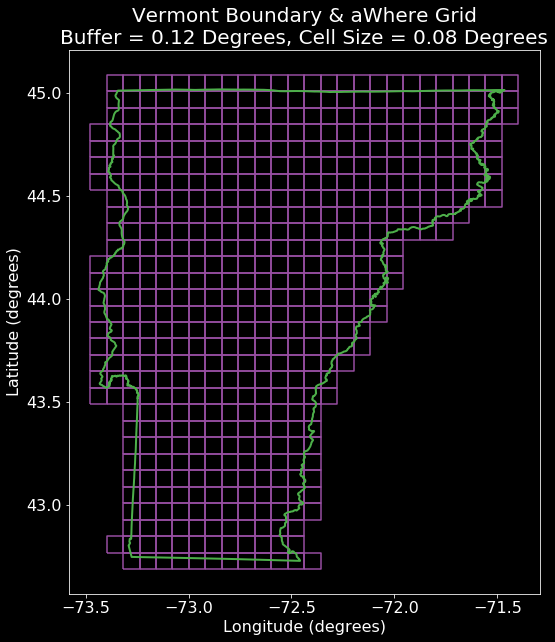

In [8]:
# Plot state boundary (4326) and grid
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(figsize=(20, 10))
    vt_grid.plot(ax=ax, facecolor="none", edgecolor="#984ea3", linewidth=1.5)
    vt_bound_4326.plot(ax=ax, facecolor="none",
                       edgecolor="#4daf4a", linewidth=2)

    ax.set_xlabel("Longitude (degrees)", fontsize=16)
    ax.set_ylabel("Latitude (degrees)", fontsize=16)
    ax.set_title(
        "Vermont Boundary & aWhere Grid\nBuffer = 0.12 Degrees, Cell Size = 0.08 Degrees",
        fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.show()

## Extract Grid Centroids

In [9]:
# Extract centroids vrom VT grid to list
vt_grid_centroids = extract_centroids(vt_grid)

In [10]:
# Show number of centroids/grid cells
len(vt_grid_centroids)

533

In [11]:
# Show first 5 centroids
vt_grid_centroids[:5]

[(-73.43784136769847, 43.527012318617274),
 (-73.43784136769847, 43.60701231861727),
 (-73.43784136769847, 43.68701231861726),
 (-73.43784136769847, 43.76701231861726),
 (-73.43784136769847, 43.84701231861727)]

In [12]:
# Show first centroid
vt_grid_centroids[:5][0]

(-73.43784136769847, 43.527012318617274)

In [13]:
# Show first longitude
vt_grid_centroids[:5][0][0]

-73.43784136769847

In [14]:
# Show first latitude
vt_grid_centroids[:5][0][-1]

43.527012318617274